In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.layers import SpatialDropout1D
from keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from sklearn.feature_selection import RFE
import re
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
train = pd.read_csv('E:/谷歌下载/kaggle-nlp/tamil_news_train.csv')
test = pd.read_csv('E:/谷歌下载/kaggle-nlp/tamil_news_test.csv')

In [ ]:
train

In [ ]:
test

In [ ]:
np.random.seed(7)
train = train.drop_duplicates().reset_index(drop=True)
test = test.drop_duplicates().reset_index(drop=True)

In [ ]:
train.NewsInTamil = train.NewsInTamil.str.replace('\d+', ' ')

test.NewsInTamil = test.NewsInTamil.str.replace('\d+', ' ')

In [9]:
train = train.append(test)
df = train
df.head()
df.shape

,NewsInEnglish,NewsInTamil,Category,CategoryInTamil
0,2017/May/19941-miss-iraq-competition-after-43-...,ஈராக்கில் ஆண்டுகள் கழித்து அழகிப்போட்டி,world,உலகம்
1,2018/Dec/55921-viswasam-s-rustic-folk-song-has...,இந்திய அளவில் ட்ரெண்ட் ஆன அஜித்தின் ‘தள்லே தில...,cinema,சினிமா
2,2018/Dec/55929-inspector-who-bought-insurance-...,சொந்த செலவில் வாகன காப்பீடு எடுத்து கொடுத்த கா...,tamilnadu,தமிழ்நாடு
3,2017/Jan/16161-morarji-desai-budget.txt,பிறந்தநாளில் பட்ஜெட் தாக்கல் செய்தவர்,india,இந்தியா
4,2018/Jun/46476-i-have-not-joined-bjp-or-anyoth...,“நானா? பாஜகவில் இணைந்துவிட்டேனா” - வரலட்சுமி வ...,cinema,சினிமா


(17331, 4)

In [10]:
df.Category.unique()

array(['world', 'cinema', 'tamilnadu', 'india', 'politics', 'sports'],
      dtype=object)

In [11]:
df.Category = df.Category.replace('world', 1)
df.Category = df.Category.replace('cinema', 2)
df.Category = df.Category.replace('tamilnadu', 3)
df.Category = df.Category.replace('india', 4)
df.Category = df.Category.replace('politics', 5)
df.Category = df.Category.replace('sports', 6)

In [12]:
MAX_NB_WORDS = 32000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 120
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=False)
tokenizer.fit_on_texts(df.NewsInTamil.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 22904 unique tokens.


In [13]:
df.Category.head()

0    1
1    2
2    3
3    4
4    2
Name: Category, dtype: int64

In [14]:
X = tokenizer.texts_to_sequences(df.NewsInTamil.values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (17331, 120)


In [15]:
Y = pd.get_dummies(df.Category).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (17331, 6)


In [16]:
train_features, test_features, train_labels, test_labels = train_test_split(X, Y, test_size=.10)

In [17]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_features, train_labels, epochs=5, batch_size=32,validation_split=0.2)
# Final evaluation of the model
model_pred_train = model.predict(train_features)
model_pred_test = model.predict(test_features)
# print(classification_report(test_labels,model_pred_test))
print('LSTM Recurrent Neural Network baseline: ' + str(roc_auc_score(train_labels, model_pred_train)))
print('LSTM Recurrent Neural Network: ' + str(roc_auc_score(test_labels, model_pred_test)))

E:\anada\envs\tensorflow\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 12477 samples, validate on 3120 samples
Epoch 1/5
12477/12477 [==============================] - 91s 7ms/step - loss: 1.2987 - accuracy: 0.5002 - val_loss: 0.8299 - val_accuracy: 0.7151
Epoch 2/5
12477/12477 [==============================] - 107s 9ms/step - loss: 0.4559 - accuracy: 0.8496 - val_loss: 0.6096 - val_accuracy: 0.7881
Epoch 3/5
12477/12477 [==============================] - 93s 7ms/step - loss: 0.1506 - accuracy: 0.9541 - val_loss: 0.6831 - val_accuracy: 0.8038
Epoch 4/5
12477/12477 [==============================] - 85s 7ms/step - loss: 0.0604 - accuracy: 0.9824 - val_loss: 0.7131 - val_accuracy: 0.7946
Epoch 5/5
12477/12477 [==============================] - 85s 7ms/step - loss: 0.0330 - accuracy: 0.9904 - val_loss: 0.8376 - val_accuracy: 0.7984
LSTM Recurrent Neural Network baseline: 0.9956016881154883
LSTM Recurrent Neural Network: 0.9547518705741526


In [19]:
model.save_weights('tamil_news_classification.h5')

Text(0.5, 1.0, 'Loss')

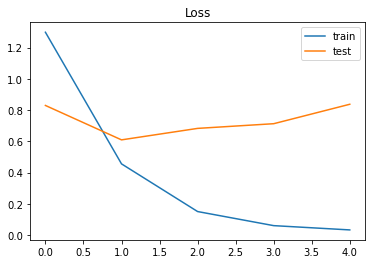

Text(0.5, 1.0, 'Accuracy')

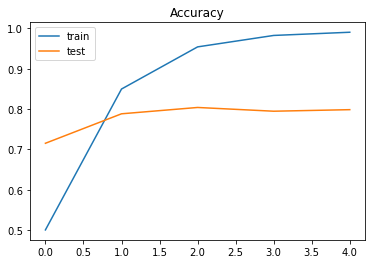

In [20]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [21]:
news = ['இயற்கையை நேசிப்பதுதானே கொண்டாட்டம்.. இது ஒரு புது முயற்சி..!']
seq = tokenizer.texts_to_sequences(news)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['world', 'cinema', 'tamilnadu', 'india', 'politics', 'sports']
label = pred, labels[np.argmax(pred)]
print("News Category is: ")
print(label[1])

News Category is: 
tamilnadu
